In [78]:
import os
import json
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt

# Fonction pour charger les données JSON
def load_json(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

# Charger les fichiers JSON
condition = load_json('/users/eleves-a/2022/janis.aiad/3A/EAP1/HFT_QR_RL/HFT_QR_RL/data/smash2/data/dbn/condition.json')
manifest = load_json('/users/eleves-a/2022/janis.aiad/3A/EAP1/HFT_QR_RL/HFT_QR_RL/data/smash2/data/dbn/manifest.json')
metadata = load_json('/users/eleves-a/2022/janis.aiad/3A/EAP1/HFT_QR_RL/HFT_QR_RL/data/smash2/data/csv/metadata.json')

# Fonction pour charger les données CSV
def load_csv(stock):
    file_path = f'/users/eleves-a/2022/janis.aiad/3A/EAP1/HFT_QR_RL/HFT_QR_RL/data/smash2/data/csv/{stock}/20240626.csv'
    return pd.read_csv(file_path)

# Spécifier le stock
stock = 'HL'
data = load_csv(stock).sample(frac=0.1, random_state=1)

# Filtrer par publisher_id = 39
data = data[data['publisher_id'] == 39]

# Convertir ts_event en datetime
data['ts_event'] = pd.to_datetime(data['ts_event'], unit='ns')
data = data.sort_values(by='ts_event')


In [79]:
data.head()

,ts_event,rtype,publisher_id,instrument_id,action,side,depth,price,size,flags,...,ask_sz_08,bid_ct_08,ask_ct_08,bid_px_09,ask_px_09,bid_sz_09,ask_sz_09,bid_ct_09,ask_ct_09,symbol
30,2024-06-26 13:30:01.145614335+00:00,10,39,7733,A,A,0,4.85,600,130,...,0,0,0,NaN,NaN,0,0,0,0,HL
63,2024-06-26 13:30:04.253249658+00:00,10,39,7733,C,A,0,4.86,1000,130,...,0,0,0,NaN,NaN,0,0,0,0,HL
77,2024-06-26 13:30:05.756353339+00:00,10,39,7733,C,A,0,4.86,1000,130,...,0,0,0,NaN,NaN,0,0,0,0,HL
88,2024-06-26 13:30:06.033855178+00:00,10,39,7733,C,B,0,4.81,600,130,...,0,0,0,NaN,NaN,0,0,0,0,HL
140,2024-06-26 13:30:10.860379015+00:00,10,39,7733,C,A,0,4.88,300,130,...,0,0,0,NaN,NaN,0,0,0,0,HL


In [83]:
# Calculer l'imbalance des meilleures offres et demandes
data['imbalance'] = (data['bid_sz_00'] - data['ask_sz_00']) / (data['bid_sz_00'] + data['ask_sz_00'])

# Calculer le prix moyen
data['mid_price'] = (data['bid_px_00'] + data['ask_px_00']) / 2

# Calculer le delta du prix moyen sur un horizon de 10 transactions
data['delta_mid_price'] = data['mid_price'].diff(periods=100)

# Filtrer les données pour ne conserver que les lignes où delta_mid_price n'est pas NaN
data_filtered = data.dropna(subset=['delta_mid_price'])

# Discrétiser l'imbalance en utilisant round(10*imbalance)
data_filtered['imbalance_bucket'] = data_filtered['imbalance'].apply(lambda x: round(7 * x))

# Calculer le delta moyen du prix par bucket d'imbalance
mean_delta_mid_price = data_filtered.groupby('imbalance_bucket')['delta_mid_price'].mean().reset_index()

# Créer une figure avec Plotly
fig = go.Figure()

# Tracer le delta moyen du prix en fonction des buckets d'imbalance
fig.add_trace(go.Scatter(x=mean_delta_mid_price['imbalance_bucket'], y=mean_delta_mid_price['delta_mid_price'], mode='lines+markers', name='Mean Delta Mid Price'))

# Mettre à jour la mise en page
fig.update_layout(title="Mean Delta Mid Price in Horizon 10 Trades vs Imbalance Buckets",
                  xaxis_title="Imbalance Buckets (round(10*imbalance))",
                  yaxis_title="Mean Delta Mid Price in Horizon 10 Trades")

# Afficher le graphique
fig.show()


/tmp/ipykernel_100807/366155553.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [82]:
print(data)

                                 ts_event  rtype  publisher_id  instrument_id  \
30    2024-06-26 13:30:01.145614335+00:00     10            39           7733   
63    2024-06-26 13:30:04.253249658+00:00     10            39           7733   
77    2024-06-26 13:30:05.756353339+00:00     10            39           7733   
88    2024-06-26 13:30:06.033855178+00:00     10            39           7733   
140   2024-06-26 13:30:10.860379015+00:00     10            39           7733   
...                                   ...    ...           ...            ...   
73218 2024-06-26 19:59:59.022678553+00:00     10            39           7733   
73230 2024-06-26 19:59:59.987236162+00:00     10            39           7733   
73234 2024-06-26 19:59:59.988039341+00:00     10            39           7733   
73235 2024-06-26 19:59:59.988079522+00:00     10            39           7733   
73237 2024-06-26 19:59:59.993085356+00:00     10            39           7733   

      action side  depth  p

In [70]:
print(data_filtered['imbalance'].unique())

# Créer une figure avec Matplotlib

[ 0.          0.66666667  0.42857143 -0.66666667 -0.42857143  0.11111111
 -0.11111111 -0.33333333  0.33333333  0.6        -0.6        -0.5
  0.5        -0.2         0.71428571  0.95121951  0.81818182  0.77777778
 -0.77777778 -0.71428571  0.75       -0.75      ]


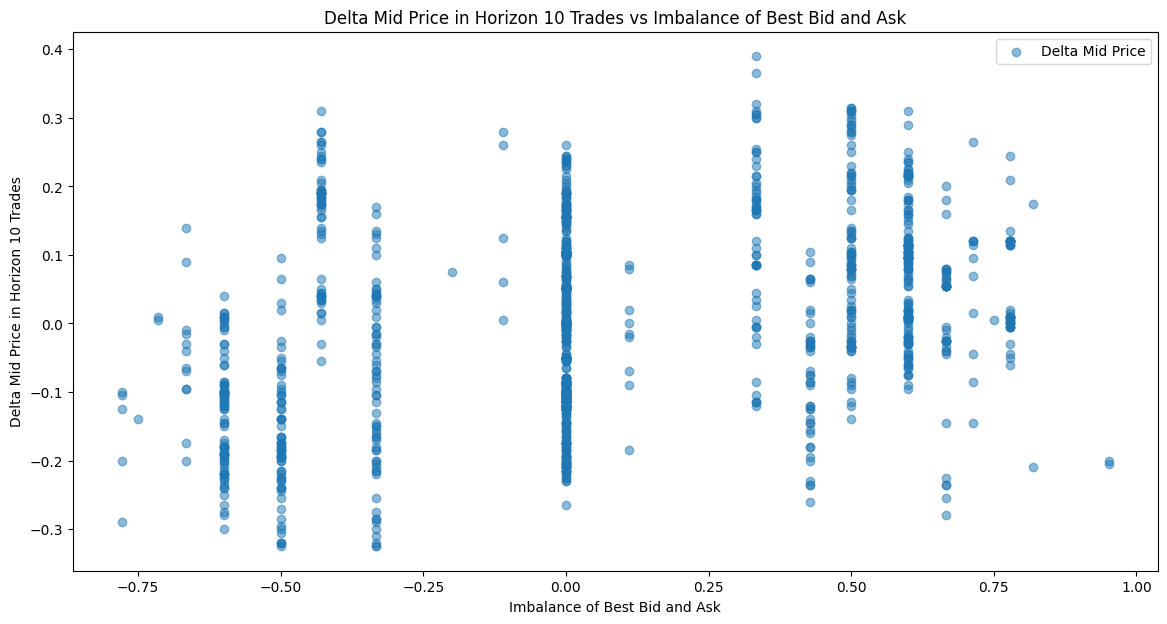

In [71]:

# Créer une figure avec Matplotlib
plt.figure(figsize=(14, 7))

# Tracer le delta du prix moyen en fonction de l'imbalance
plt.scatter(data_filtered['imbalance'], data_filtered['delta_mid_price'], alpha=0.5, label='Delta Mid Price')

# Mettre à jour la mise en page
plt.title("Delta Mid Price in Horizon 10 Trades vs Imbalance of Best Bid and Ask")
plt.xlabel("Imbalance of Best Bid and Ask")
plt.ylabel("Delta Mid Price in Horizon 10 Trades")
plt.legend()

# Afficher le graphique
plt.show()
